In [52]:
import numpy as np
import matplotlib.pyplot as plt

#第一步：初始化

# 求解区域的范围
x_range = [0.0, 1.0]
y_range = [0.0, 1.0]

# 划分的步长
h = 0.01

# 每一个点的坐标
x = np.arange(x_range[0], x_range[1]+h, h)
y = np.arange(y_range[0], y_range[1]+h, h)

# 格点数目
x_n_grid = len(x)
y_n_grid = len(y)

# 边界点和求解区域，边界点标记为True，待求点标记为False
area = np.full(shape=(x_n_grid, y_n_grid), fill_value=True)
area[1: -1, 1: -1] = np.full(shape=(x_n_grid-2, y_n_grid-2), fill_value=False)
print(area)
for i in range(x_n_grid):
    area[i, x_n_grid - i - 1] = True

# 建立编号矩阵，其中的每一个编号对应区域中的一个节点
index_matrix = np.zeros((x_n_grid, y_n_grid), dtype=int)
k = 0

# 先对内部节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if not area[i, j]:
            index_matrix[i, j] = k
            k += 1
        if i + j == x_n_grid - 1:
            break
            
# 内部节点数            
n_inner = k

# 然后对边界节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if area[i, j]:
            index_matrix[i, j] = k
            k += 1
        if i + j == x_n_grid - 1:
            break


# 边界节点数        
n_edge = k - n_inner

print(area)

print(index_matrix)

[[ True  True  True ...  True  True  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True False False ... False  True  True]
 [ True False False ...  True False  True]
 ...
 [ True False  True ... False False  True]
 [ True  True False ... False False  True]
 [ True  True  True ...  True  True  True]]
[[4851 4852 4853 ... 4949 4950 4951]
 [4952    0    1 ...   97 4953    0]
 [4954   98   99 ... 4955    0    0]
 ...
 [5146 4850 5147 ...    0    0    0]
 [5148 5149    0 ...    0    0    0]
 [5150    0    0 ...    0    0    0]]


In [53]:
# 第二步：划分区域
class element:
    def __init__(self, index_list, x_list, y_list):
        # 记录三角形元素的三个节点编号和坐标
        self.index = index_list
        self.x = x_list
        self.y = y_list
        # 计算三角形元素的b和c
        self.b = [self.y[(i+1)%3]-self.y[(i+2)%3] for i in range(3)]
        self.c = [self.x[(i+2)%3]-self.x[(i+1)%3] for i in range(3)]

e_list = []

for i in range(x_n_grid-1):
    for j in range(1, y_n_grid): #（i,j）是固定参考点
        if(i + j < x_n_grid - 1):
            e_list.append(
            element(
                index_list=[index_matrix[i, j], index_matrix[i, j-1], index_matrix[i+1, j-1]],
                x_list=[x[i], x[i], x[i+1]],
                y_list=[y[j], y[j-1], y[j-1]]
                )
            )
            e_list.append(
                element(
                    index_list=[index_matrix[i, j], index_matrix[i+1, j-1], index_matrix[i+1, j]],
                    x_list=[x[i], x[i+1], x[i+1]],
                    y_list=[y[j], y[j-1], y[j]]
                    )
                )
        if(i + j == x_n_grid - 1):  
            e_list.append(
                element(
                    index_list=[index_matrix[i, j], index_matrix[i, j-1], index_matrix[i+1, j-1]],
                    x_list=[x[i], x[i], x[i+1]],
                    y_list=[y[j], y[j-1], y[j-1]]
                    )
            )
            break
        

# 第三步：建立矩阵

Delta = (x_range[1] - x_range[0])*(y_range[1] - y_range[0])/len(e_list)/2
print(len(e_list))

K = np.zeros((n_inner + n_edge, n_inner + n_edge))

# K矩阵是对称的，所以只计算一半
for e in e_list:
    for i in range(3):
        for j in range(i, 3):
            K[e.index[i], e.index[j]] += (e.b[i]*e.b[j] + e.c[i]*e.c[j])/4/Delta

# 根据对称性补全K矩阵
K += K.T - np.diag(np.diag(K))
print(K)




10000
[[ 4.  -1.   0.  ...  0.   0.   0. ]
 [-1.   4.  -1.  ...  0.   0.   0. ]
 [ 0.  -1.   4.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -1.  -0.5]
 [ 0.   0.   0.  ... -1.   2.   0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]


In [65]:

#边界条件
Phi_2 = np.ones((n_edge, 1))
for i in range(x_n_grid):
    Phi_2[index_matrix[i,0]-index_matrix[0,0],0] = 0


K_11 = K[:n_inner, :n_inner]
K_12 = K[:n_inner, n_inner:]
A = K_11
b = -K_12.dot(Phi_2)

# 使用矩阵解
X = np.linalg.inv(A) @ b


X = np.hstack((X.T, Phi_2.T))
print(X.shape)
print(X)

value_matrix = np.zeros((x_n_grid, y_n_grid))

# 将解填入求解区域中
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if(i + j <= x_n_grid - 1):
            value_matrix[i, j] = X[0,index_matrix[i, j]]
        if(i + j > x_n_grid - 1): #填入空白
            value_matrix[i, j] = None

print(value_matrix)


(1, 5151)
[[0.50021887 0.69809029 0.7912668  ... 0.         1.         0.        ]]
[[0.         1.         1.         ... 1.         1.         1.        ]
 [0.         0.50021887 0.69809029 ... 0.99999977 1.                nan]
 [0.         0.3027852  0.50087549 ... 1.                nan        nan]
 ...
 [0.         0.60469468 1.         ...        nan        nan        nan]
 [0.         1.                nan ...        nan        nan        nan]
 [0.                nan        nan ...        nan        nan        nan]]


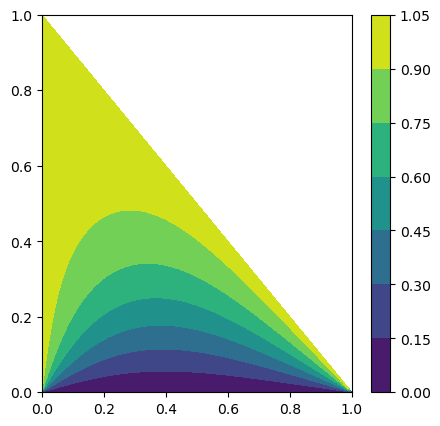

In [72]:
#作图
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.contourf(x, y, value_matrix.T)
plt.colorbar()
plt.show()